In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

In [ ]:
!unzip /content/intel-image-classification.zip

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, GlobalAveragePooling2D, MaxPool2D
from keras.models import Model

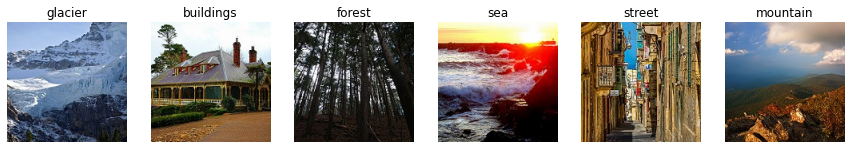

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(15,10))
columns = 6
rows = 1
fielName = "/content/seg_train/seg_train"

for i in range(0, columns*rows ):
  folderName = os.path.join((fielName), os.listdir(fielName)[i])
  img = cv2.imread(folderName+'/'+(os.listdir(os.path.join((fielName), os.listdir(fielName)[i]))[i]))
  fig.add_subplot(rows, columns, i+1)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title(os.path.basename(folderName))

plt.show()

In [ ]:
batch_size = 32
resize = (224, 224)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_std_normalization=True) 

validation_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
        '/content/seg_train/seg_train', 
        target_size=resize, 
        batch_size=batch_size,
        class_mode='categorical')  

validation_generator = validation_datagen.flow_from_directory(
        '/content/seg_test/seg_test',
        target_size=resize,
        batch_size=batch_size,
        class_mode='categorical')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback
from keras.callbacks import LambdaCallback


     |████████████████████████████████| 1.7 MB 10.1 MB/s 
     |████████████████████████████████| 180 kB 8.9 MB/s 
     |████████████████████████████████| 144 kB 24.4 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 


In [ ]:
!wandb login
wandb.init(project="ResNet", entity="manar")

In [ ]:
input = Input((224,224,3))
X = Conv2D(64, (7,7), (2,2), padding="same", kernel_initializer=glorot_uniform(seed=0))(input)
X = BatchNormalization(axis=3)(X)
X = Activation("relu")(X)
X = MaxPool2D((3,3), (2,2),padding="same")(X)

def layer(itr, input, filters, stride):
  f1,f2,f3 = filters
  X = Conv2D(f1, (1,1), stride, padding="valid", kernel_initializer=glorot_uniform(seed=0))(input)
  X = BatchNormalization(axis=3)(X)
  X = Activation("relu")(X)
  X = Conv2D(f2, (3,3), (1,1), padding="same", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation("relu")(X)
  X = Conv2D(f3, (1,1), (1,1), padding="valid", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation("relu")(X)
  block = Conv2D(f3, (1,1), stride, padding="valid", kernel_initializer=glorot_uniform(seed=0))(input)
  block = BatchNormalization(axis=3)(block)
  X = Add()([X, block])
  X = Activation("relu")(X)

  for iteration in range(itr-1):
    X = Conv2D(f1, (1,1), (1,1), padding="valid", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)
    X = Conv2D(f2, (3,3), (1,1), padding="same", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)
    X = Conv2D(f3, (1,1), (1,1), padding="valid", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Add()([X, block])
    X = Activation("relu")(X)
  return X

X = layer(3, X, filters=[64,64,256], stride=(1,1))
X = layer(4, X, filters=[128,128,512], stride=(2,2))
X = layer(6, X, filters=[256,256,1024], stride=(2,2))
X = layer(3, X, filters=[512,512,2048], stride=(2,2))
X = GlobalAveragePooling2D()(X)
process_model = Model(input, X)

In [ ]:
result_model = process_model.output
result_model = Flatten()(result_model)
result_model = Dense(1000)(result_model)
result_model = Activation("relu")(result_model)
result_model = Dense(6)(result_model)
result_model = Activation("softmax")(result_model)

In [ ]:
model = Model(inputs=process_model.input, outputs=result_model)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_159 (Conv2D)            (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_159 (Batch  (None, 112, 112, 64  256        ['conv2d_159[0][0]']             
 Normalization)                 )                                                           

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(train_generator, validation_data=validation_generator, epochs=10, callbacks=[WandbCallback()])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
439/439 [==============================] - ETA: 0s - loss: 0.9718 - accuracy: 0.6352

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


439/439 [==============================] - 354s 766ms/step - loss: 0.9718 - accuracy: 0.6352 - val_loss: 35.2261 - val_accuracy: 0.1587
Epoch 2/10
439/439 [==============================] - 331s 755ms/step - loss: 0.6444 - accuracy: 0.7577 - val_loss: 5.2900 - val_accuracy: 0.2837
Epoch 3/10
439/439 [==============================] - 332s 756ms/step - loss: 0.5559 - accuracy: 0.7912 - val_loss: 2.2754 - val_accuracy: 0.3850
Epoch 4/10
439/439 [==============================] - 331s 755ms/step - loss: 0.5198 - accuracy: 0.8112 - val_loss: 0.6427 - val_accuracy: 0.7813
Epoch 5/10
439/439 [==============================] - 332s 755ms/step - loss: 0.4738 - accuracy: 0.8316 - val_loss: 0.6199 - val_accuracy: 0.7650
Epoch 6/10
439/439 [==============================] - 332s 756ms/step - loss: 0.4309 - accuracy: 0.8447 - val_loss: 0.5795 - val_accuracy: 0.7853
Epoch 7/10
439/439 [==============================] - 331s 754ms/step - loss: 0.4087 - accuracy: 0.8545 - val_loss: 0.5420 - val_accur